# Examine a sample image

Much of what is describe here has been borrowed from the following resources
https://github.com/blaylockbk/pyBKB_v2/blob/master/BB_goes16/mapping_GOES16_data.ipynb
http://edc.occ-data.org/goes16/python/
http://www.ceda.ac.uk/static/media/uploads/ncas-reading-2015/10_read_netcdf_python.pdf

## Import the libraries and set working directory

In [105]:
%matplotlib inline
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os 
from pyproj import Proj
import datetime
from mpl_toolkits.basemap import Basemap
from osgeo import gdal
import itertools
import re

os.chdir("/Users/nathan/Documents/Projects/GOES_Fire_Growth/Raw_Data")

## Import dataset and examine dimensions

In [5]:
C_file = Dataset("OR_ABI-L2-CMIPC-M3C07_G16_s20172830932227_e20172830935012_c20172830935048.nc", 'r')
ref_ch7 = C_file.variables['CMI'][:]
#C_file.close()
#C_file = None
print C_file.file_format
dims = C_file.dimensions.keys()
print dims
for dim in dims:
    print C_file.dimensions[dim]

NETCDF4
[u'y', u'x', u'number_of_time_bounds', u'band', u'number_of_image_bounds']
<type 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 1500

<type 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 2500

<type 'netCDF4._netCDF4.Dimension'>: name = 'number_of_time_bounds', size = 2

<type 'netCDF4._netCDF4.Dimension'>: name = 'band', size = 1

<type 'netCDF4._netCDF4.Dimension'>: name = 'number_of_image_bounds', size = 2



## Examine Variables

In [6]:
print C_file.variables.keys()
print C_file.variables["goes_imager_projection"]

[u'CMI', u'DQF', u't', u'y', u'x', u'time_bounds', u'goes_imager_projection', u'y_image', u'y_image_bounds', u'x_image', u'x_image_bounds', u'nominal_satellite_subpoint_lat', u'nominal_satellite_subpoint_lon', u'nominal_satellite_height', u'geospatial_lat_lon_extent', u'band_wavelength', u'band_id', u'total_number_of_points', u'valid_pixel_count', u'outlier_pixel_count', u'min_brightness_temperature', u'max_brightness_temperature', u'mean_brightness_temperature', u'std_dev_brightness_temperature', u'esun', u'kappa0', u'planck_fk1', u'planck_fk2', u'planck_bc1', u'planck_bc2', u'algorithm_dynamic_input_data_container', u'percent_uncorrectable_GRB_errors', u'percent_uncorrectable_L0_errors', u'earth_sun_distance_anomaly_in_AU', u'processing_parm_version_container', u'algorithm_product_version_container']
<type 'netCDF4._netCDF4.Variable'>
int32 goes_imager_projection()
    long_name: GOES-R ABI fixed grid projection
    grid_mapping_name: geostationary
    perspective_point_height: 35786

## Get time

In [81]:
# Data are stored as seconds since 2000-01-01 12:00:00
secs = int(round(C_file.variables['t'][0], 0)) # Round to nearest second
img_date = datetime.datetime(2000, 1, 1, 12) + datetime.timedelta(seconds = secs)

## Get image data

Text(0.5,1,u'2017-10-10 09:33:41.995620')

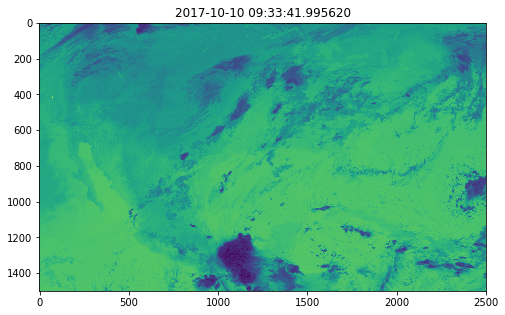

In [8]:
b = C_file.variables['CMI']

# Plot it
plt.figure(figsize = [8,8])
plt.imshow(b)
plt.title(img_date)

Text(0.5,1,u'2017-10-10 09:33:41.995620')

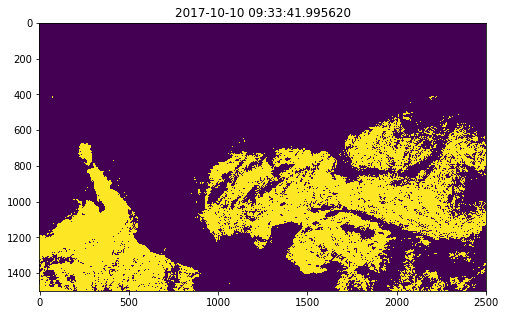

In [53]:
bt = np.array(b) > 295

# Plot it
plt.figure(figsize = [8,8])
plt.imshow(bt)
plt.title(img_date)

## Get projection and location info

In [55]:
sh = C_file.variables['goes_imager_projection'].perspective_point_height
slon = C_file.variables['goes_imager_projection'].longitude_of_projection_origin
ssweep = C_file.variables['goes_imager_projection'].sweep_angle_axis

# Get coordinates
xcoords = C_file.variables['x'][:] * sh
ycoords = C_file.variables['y'][:] * sh

# Convert to lat lon
p = Proj(proj = "geos", h = sh, lon_0 = slon, sweep = ssweep)
Xs, Ys = np.meshgrid(xcoords, ycoords)
lons, lats = p(Xs, Ys, inverse = True)
#print(lons.shape)

(1500, 2500)


## Subset to North Bay area

Text(0.5,1,u'2017-10-10 09:33:41.995620')

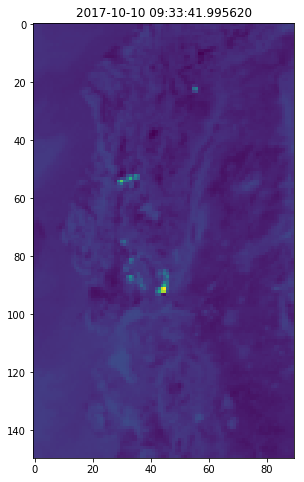

In [59]:
nbb = b[325:475, 30:120]
nblons = lons[325:475, 30:120]
nblats = lats[325:475, 30:120]

# Plot it
plt.figure(figsize = [8,8])
plt.imshow(nbb)
plt.title(img_date)

(array([  4.01500000e+03,   9.30000000e+03,   1.50000000e+02,
          1.90000000e+01,   8.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          2.00000000e+00]),
 array([ 273.63452148,  279.92592773,  286.21733398,  292.50874023,
         298.80014648,  305.09155273,  311.38295898,  317.67436523,
         323.96577148,  330.25717773,  336.54858398]),
 <a list of 10 Patch objects>)

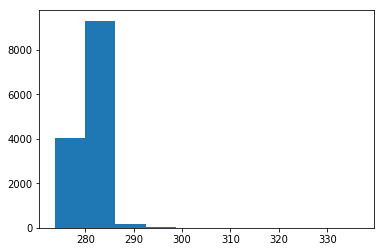

In [45]:
# Histogram
plt.hist(np.concatenate(nbb))

Text(0.5,1,u'2017-10-10 09:33:42')

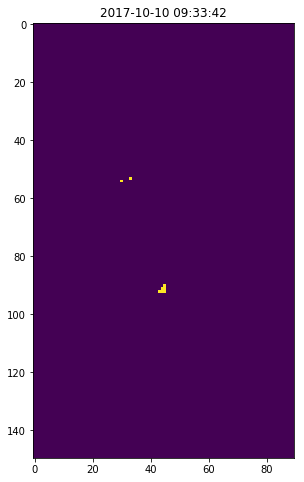

In [104]:
# Plot logical raster of fire/no fire
nbbt = nbb > 310

# Plot it
plt.figure(figsize = [8,8])
plt.imshow(nbbt)
plt.title(img_date)

## Try writing raster

In [54]:
# This doesn't work because geotiff doesn't play well 
# with this geos projection

driver = gdal.GetDriverByName('GTiff')
new_file = driver.Create('test_band1.tif', 
                        C_file.dimensions['x'].size, # number of columns
                        C_file.dimensions['y'].size, # number of rows
                        1, # number of bands
                        gdal.GDT_Float32) # datatype

help(Proj.srs)
print(dir(p))
new_file.SetProjection(p.srs)
new_band = new_file.GetRasterBand(1)
new_band.WriteArray(np.array(b))

Help on getset descriptor _proj.Proj.srs:

srs

['__call__', '__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_fwd', '_inv', 'is_geocent', 'is_latlong', 'proj_version', 'srs', 'to_latlong']


0

## Save lat/lon locations to csv

In [106]:
# Get locations
firelat = nblats[nbbt]
firelon = nblons[nbbt]

# Join to array
dates_str = list(itertools.repeat(str(img_date), len(firelat)))
outarray = np.column_stack((dates_str, 
                            firelat, firelon))

#print(outarray)

# Write to csv
out_file = "../Fire_Points/fire_points_" + re.sub(" ", "-",
    re.sub(":", "-", str(img_date))) + ".csv"
np.savetxt(fname = out_file, X = outarray, 
           delimiter = ",", fmt = '%s, %s, %s', header = "Date, Lat, Lon")